In [5]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim



In [6]:
df=pd.read_csv('./cleaned_data/cleaned_yellow_taxi.csv')
df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,source_file,taxi_type,trip_duration_minutes,pickup_hour,pickup_day,pickup_month
0,2025-01-18 20:53:30,2025-01-18 21:00:47,1.0,0.97,238,166,1,8.6,1.00,0.5,...,13.32,0.0,0.0,0.00,yellow_tripdata_2025-01.parquet,yellow,7.283333,20,Saturday,1
1,2025-01-25 11:12:51,2025-01-25 11:17:57,1.0,0.60,50,48,2,5.8,3.25,0.5,...,10.55,2.5,0.0,0.75,yellow_tripdata_2025-01.parquet,yellow,5.100000,11,Saturday,1
2,2025-01-21 15:09:31,2025-01-21 15:19:02,1.0,0.80,236,237,1,9.3,2.50,0.5,...,16.65,2.5,0.0,0.00,yellow_tripdata_2025-01.parquet,yellow,9.516667,15,Tuesday,1
3,2025-01-04 23:37:07,2025-01-04 23:45:58,1.0,4.44,137,88,0,26.3,0.00,0.5,...,35.12,2.5,0.0,0.00,yellow_tripdata_2025-01.parquet,yellow,8.850000,23,Saturday,1
4,2025-01-29 00:31:22,2025-01-29 00:38:27,1.0,1.10,140,263,1,7.9,3.50,0.5,...,15.48,2.5,0.0,0.00,yellow_tripdata_2025-01.parquet,yellow,7.083333,0,Wednesday,1


In [7]:
print(df.columns)

Index(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee', 'source_file', 'taxi_type',
       'trip_duration_minutes', 'pickup_hour', 'pickup_day', 'pickup_month'],
      dtype='object')


In [8]:
# Select features that actually exist in the dataset
print("Available columns in dataset:")
print(df.columns.tolist())

# Select appropriate features for the model (excluding target and non-predictive columns)
# Removed PULocationID, DOLocationID, and total_amount for simplified UI-based prediction
feature_columns = [
    'passenger_count', 'trip_distance',
    'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'payment_type', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee',
    'trip_duration_minutes', 'pickup_hour', 'pickup_day', 'pickup_month'
]

# Note: We're excluding 'pickup_datetime', 'dropoff_datetime', 'source_file', 'taxi_type'
# as they are either non-predictive or already converted to useful features
# Also excluding 'PULocationID', 'DOLocationID', 'total_amount' for simplified UI prediction

print(f"\nSelected feature columns ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

# Verify all columns exist
missing_cols = [col for col in feature_columns if col not in df.columns]
if missing_cols:
    print(f"\n❌ Missing columns: {missing_cols}")
else:
    print(f"\n✅ All feature columns found!")

X = df[feature_columns]
y = df['fare_amount']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Number of features: {len(feature_columns)}")

Available columns in dataset:
['pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'source_file', 'taxi_type', 'trip_duration_minutes', 'pickup_hour', 'pickup_day', 'pickup_month']

Selected feature columns (14):
 1. passenger_count
 2. trip_distance
 3. extra
 4. mta_tax
 5. tip_amount
 6. tolls_amount
 7. payment_type
 8. congestion_surcharge
 9. Airport_fee
10. cbd_congestion_fee
11. trip_duration_minutes
12. pickup_hour
13. pickup_day
14. pickup_month

✅ All feature columns found!

Feature matrix shape: (349747, 14)
Target vector shape: (349747,)
Number of features: 14


In [9]:
# Check data shapes and prepare for PyTorch
print("=== DATA PREPARATION ===")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X columns: {list(X.columns)}")
print(f"Target variable: fare_amount")

# Check for any missing values
print(f"\nMissing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

# Basic statistics
print(f"\nTarget statistics:")
print(f"y mean: {y.mean():.2f}")
print(f"y std: {y.std():.2f}")
print(f"y min: {y.min():.2f}")
print(f"y max: {y.max():.2f}")

=== DATA PREPARATION ===
X shape: (349747, 14)
y shape: (349747,)
X columns: ['passenger_count', 'trip_distance', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'payment_type', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'trip_duration_minutes', 'pickup_hour', 'pickup_day', 'pickup_month']
Target variable: fare_amount

Missing values in X: 0
Missing values in y: 0

Target statistics:
y mean: 12.68
y std: 6.96
y min: -6.70
y max: 32.40


### Custom Dataset Class for Taxi Fare Prediction



In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class TaxiFareDataset(Dataset):
    """
    Custom Dataset class for taxi fare prediction
    """
    def __init__(self, features, targets, transform=True):
        """
        Args:
            features (pandas.DataFrame): Input features (X)
            targets (pandas.Series): Target values (y)
            transform (bool): Whether to apply standardization
        """
        self.features = features.copy()
        self.targets = targets.copy()
        
        # Handle categorical columns (convert to numeric if needed)
        if 'pickup_day' in self.features.columns:
            # Convert day names to numbers if they're strings
            if self.features['pickup_day'].dtype == 'object':
                day_mapping = {
                    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
                    'Friday': 4, 'Saturday': 5, 'Sunday': 6
                }
                self.features['pickup_day'] = self.features['pickup_day'].map(day_mapping)
        
        # Handle any remaining categorical columns
        for col in self.features.columns:
            if self.features[col].dtype == 'object':
                print(f"Converting categorical column {col} to numeric")
                self.features[col] = pd.Categorical(self.features[col]).codes
        
        # Convert to numpy arrays
        self.features = self.features.values.astype(np.float32)
        self.targets = self.targets.values.astype(np.float32)
        
        # Apply standardization if requested
        if transform:
            self.scaler = StandardScaler()
            self.features = self.scaler.fit_transform(self.features)
        else:
            self.scaler = None
        
        # Convert to tensors
        self.x_data = torch.tensor(self.features, dtype=torch.float32)
        self.y_data = torch.tensor(self.targets, dtype=torch.float32)
        
        print(f"Dataset created with {len(self)} samples")
        print(f"Feature shape: {self.x_data.shape}")
        print(f"Target shape: {self.y_data.shape}")
        print(f"Feature statistics:")
        print(f"  Mean: {self.x_data.mean(dim=0)[:5]}...")  # Show first 5 features
        print(f"  Std: {self.x_data.std(dim=0)[:5]}...")

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Create train-test split
print("=== SPLITTING DATA ===")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check for any missing values before creating datasets
print(f"\nMissing values check:")
print(f"X_train missing: {X_train.isnull().sum().sum()}")
print(f"X_test missing: {X_test.isnull().sum().sum()}")
print(f"y_train missing: {y_train.isnull().sum()}")
print(f"y_test missing: {y_test.isnull().sum()}")

# Create datasets
train_dataset = TaxiFareDataset(X_train, y_train, transform=True)
test_dataset = TaxiFareDataset(X_test, y_test, transform=True)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")
print(f"Input feature size: {train_dataset.x_data.shape[1]}")

=== SPLITTING DATA ===
Training set: 279797 samples
Test set: 69950 samples

Missing values check:
X_train missing: 0
X_test missing: 0
y_train missing: 0
y_test missing: 0
Dataset created with 279797 samples
Feature shape: torch.Size([279797, 14])
Target shape: torch.Size([279797])
Feature statistics:
  Mean: tensor([ 0.0000e+00, -9.7618e-09,  6.2825e-08,  5.2354e-09,  1.4179e-08])...
  Std: tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000])...
Dataset created with 69950 samples
Feature shape: torch.Size([69950, 14])
Target shape: torch.Size([69950])
Feature statistics:
  Mean: tensor([ 0.0000e+00, -1.3634e-08,  2.9803e-08,  1.9414e-08,  1.9196e-08])...
  Std: tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000])...

DataLoaders created:
Train batches: 4372
Test batches: 1093
Batch size: 64
Input feature size: 14
  Mean: tensor([ 0.0000e+00, -9.7618e-09,  6.2825e-08,  5.2354e-09,  1.4179e-08])...
  Std: tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000])...
Dataset created with 69950 samples
Fe

### Neural Network Model for Taxi Fare Prediction


In [11]:
class TaxiFareModel(nn.Module):
    """
    Deep Neural Network for taxi fare prediction
    """
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.2):
        super(TaxiFareModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Build hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Output layer (single neuron for regression)
        layers.append(nn.Linear(prev_size, 1))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x).squeeze()

# Initialize model
input_size = X.shape[1]  # Number of features
model = TaxiFareModel(input_size=input_size)

print(f"=== MODEL ARCHITECTURE ===")
print(f"Input size: {input_size} features")
print(f"Model: {model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10)

print(f"\nOptimizer: Adam")
print(f"Loss function: MSE")
print(f"Learning rate: 0.001")

=== MODEL ARCHITECTURE ===
Input size: 14 features
Model: TaxiFareModel(
  (model): Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total parameters: 12737

Optimizer: Adam
Loss function: MSE
Learning rate: 0.001


### Training and Evaluation Functions


In [12]:
def train_model(model, train_loader, criterion, optimizer, device='cpu'):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    return total_loss / num_batches

def evaluate_model(model, test_loader, criterion, device='cpu'):
    """Evaluate the model"""
    model.eval()
    total_loss = 0.0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    
    # Calculate additional metrics
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    
    # R² score
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return avg_loss, mse, rmse, mae, r2, predictions, actuals

print("Training and evaluation functions defined!")
print("Ready to start training the model...")

Training and evaluation functions defined!
Ready to start training the model...


In [13]:
# Training Loop
def train_taxi_fare_model(num_epochs=50):
    """Main training loop"""
    print("=== STARTING TRAINING ===")
    
    # Track training history
    train_losses = []
    val_losses = []
    val_rmses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Train
        train_loss = train_model(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        
        # Evaluate
        val_loss, mse, rmse, mae, r2, _, _ = evaluate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_rmses.append(rmse)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), './best_models/best_taxi_fare_model_copy.pth')
            print("✓ New best model saved!")
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(val_rmses, label='Validation RMSE', color='orange')
    plt.title('Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    # Final evaluation
    final_loss, final_mse, final_rmse, final_mae, final_r2, predictions, actuals = evaluate_model(model, test_loader, criterion)
    
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.xlabel('Actual Fare')
    plt.ylabel('Predicted Fare')
    plt.title(f'Predictions vs Actuals\nR² = {final_r2:.4f}')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== FINAL RESULTS ===")
    print(f"Final Test RMSE: ${final_rmse:.2f}")
    print(f"Final Test MAE: ${final_mae:.2f}")
    print(f"Final R² Score: {final_r2:.4f}")
    
    return train_losses, val_losses, val_rmses

print("Training function ready!")
print("Call train_taxi_fare_model() to start training")

Training function ready!
Call train_taxi_fare_model() to start training


=== STARTING TRAINING ===

Epoch 1/50
--------------------------------------------------
Batch 0/4372, Loss: 219.9959
Batch 100/4372, Loss: 174.1669
Batch 100/4372, Loss: 174.1669
Batch 200/4372, Loss: 187.5647
Batch 200/4372, Loss: 187.5647
Batch 300/4372, Loss: 190.9444
Batch 300/4372, Loss: 190.9444
Batch 400/4372, Loss: 133.8721
Batch 400/4372, Loss: 133.8721
Batch 500/4372, Loss: 126.4068
Batch 500/4372, Loss: 126.4068
Batch 600/4372, Loss: 98.6347
Batch 600/4372, Loss: 98.6347
Batch 700/4372, Loss: 91.9769
Batch 700/4372, Loss: 91.9769
Batch 800/4372, Loss: 75.3459
Batch 800/4372, Loss: 75.3459
Batch 900/4372, Loss: 39.6110
Batch 900/4372, Loss: 39.6110
Batch 1000/4372, Loss: 23.6712
Batch 1000/4372, Loss: 23.6712
Batch 1100/4372, Loss: 25.6798
Batch 1100/4372, Loss: 25.6798
Batch 1200/4372, Loss: 45.5242
Batch 1200/4372, Loss: 45.5242
Batch 1300/4372, Loss: 17.1295
Batch 1300/4372, Loss: 17.1295
Batch 1400/4372, Loss: 17.2110
Batch 1400/4372, Loss: 17.2110
Batch 1500/4372, Loss:

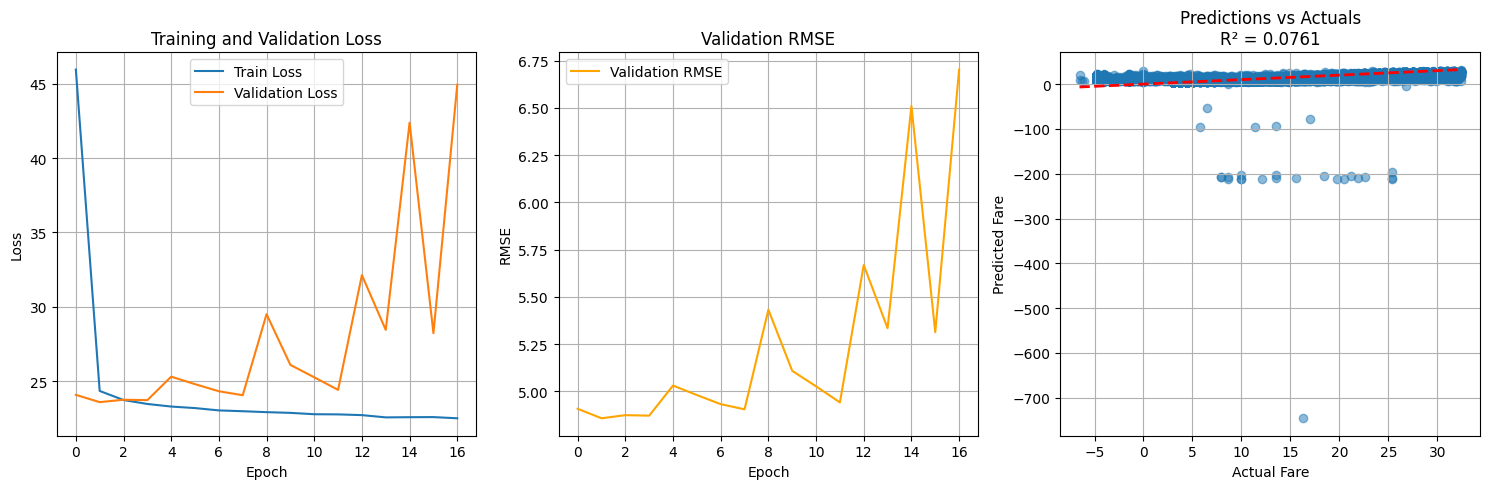


=== FINAL RESULTS ===
Final Test RMSE: $6.70
Final Test MAE: $2.46
Final R² Score: 0.0761


([45.95553807184877,
  24.34198947914783,
  23.73287301432181,
  23.466713420535488,
  23.293273611343572,
  23.189994403831694,
  23.0340274042311,
  22.978844155767916,
  22.91601455200733,
  22.869256327158798,
  22.776732406262838,
  22.766381483937444,
  22.71699930911531,
  22.564709890139614,
  22.577457045483566,
  22.584066301338844,
  22.50391539726798],
 [24.080560381000236,
  23.59001613623051,
  23.751416304955654,
  23.725207346246968,
  25.303453928815696,
  24.798701831428478,
  24.32260837646547,
  24.053944914033405,
  29.503676523555885,
  26.093112048160453,
  25.262121450759246,
  24.413241964900372,
  32.13101573614276,
  28.449250329009786,
  42.38331769609931,
  28.22606390850978,
  44.93383142649309],
 [4.9071603,
  4.8569202,
  4.873503,
  4.8708115,
  5.0302305,
  4.979806,
  4.931765,
  4.9044456,
  5.4317183,
  5.1081176,
  5.026119,
  4.940949,
  5.668422,
  5.333772,
  6.5102696,
  5.312808,
  6.703298])

In [14]:
train_taxi_fare_model()

In [15]:
# Sample Input and Prediction Function
def predict_fare(model, sample_input, scaler=None):
    """
    Make a prediction for a single trip or batch of trips
    
    Args:
        model: Trained PyTorch model
        sample_input: Dictionary with feature values or numpy array
        scaler: StandardScaler used during training (if available)
    
    Returns:
        Predicted fare amount
    """
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        # If input is a dictionary, convert to array
        if isinstance(sample_input, dict):
            # Define the expected feature order (same as training)
            feature_order = [
                'passenger_count', 'trip_distance',
                'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                'payment_type', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee',
                'trip_duration_minutes', 'pickup_hour', 'pickup_day', 'pickup_month'
            ]
            
            # Convert pickup_day to numeric if it's a string
            if 'pickup_day' in sample_input and isinstance(sample_input['pickup_day'], str):
                day_mapping = {
                    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
                    'Friday': 4, 'Saturday': 5, 'Sunday': 6
                }
                sample_input['pickup_day'] = day_mapping.get(sample_input['pickup_day'], 0)
            
            # Create array in correct order
            input_array = np.array([[sample_input[feature] for feature in feature_order]], dtype=np.float32)
        else:
            input_array = np.array(sample_input, dtype=np.float32)
            if input_array.ndim == 1:
                input_array = input_array.reshape(1, -1)
        
        # Apply scaling if scaler is provided
        if scaler is not None:
            input_array = scaler.transform(input_array)
        
        # Convert to tensor
        input_tensor = torch.tensor(input_array, dtype=torch.float32)
        
        # Make prediction
        prediction = model(input_tensor)
        
        # Return as float (remove tensor wrapper)
        return prediction.item() if prediction.numel() == 1 else prediction.numpy()

# Example 1: Using a dictionary input (most user-friendly)
print("=== SAMPLE PREDICTION EXAMPLES ===")

# Updated sample trip data with correct features (excluding location IDs and total_amount)
sample_trip = {
    'passenger_count': 1,
    'trip_distance': 8.5,     # miles
    'extra': 0.5,
    'mta_tax': 0.5,
    'tip_amount': 3.0,
    'tolls_amount': 0.0,
    'payment_type': 1,        # Credit card
    'congestion_surcharge': 2.5,
    'Airport_fee': 0.0,
    'cbd_congestion_fee': 0.75,
    'trip_duration_minutes': 25,
    'pickup_hour': 14,        # 2 PM
    'pickup_day': 'Friday',   # Will be converted to 4
    'pickup_month': 1         # January
}

print("Sample trip details:")
for key, value in sample_trip.items():
    print(f"  {key}: {value}")

print(f"\nExpected feature order ({len(feature_columns)} features):")
for i, feature in enumerate(feature_columns, 1):
    print(f"{i:2d}. {feature}")

# Make prediction (you'll need to run this after training the model)
print("\n# To make a prediction, run:")
print("predicted_fare = predict_fare(model, sample_trip, train_dataset.scaler)")
print("print(f'Predicted fare: ${predicted_fare:.2f}')")

=== SAMPLE PREDICTION EXAMPLES ===
Sample trip details:
  passenger_count: 1
  trip_distance: 8.5
  extra: 0.5
  mta_tax: 0.5
  tip_amount: 3.0
  tolls_amount: 0.0
  payment_type: 1
  congestion_surcharge: 2.5
  Airport_fee: 0.0
  cbd_congestion_fee: 0.75
  trip_duration_minutes: 25
  pickup_hour: 14
  pickup_day: Friday
  pickup_month: 1

Expected feature order (14 features):
 1. passenger_count
 2. trip_distance
 3. extra
 4. mta_tax
 5. tip_amount
 6. tolls_amount
 7. payment_type
 8. congestion_surcharge
 9. Airport_fee
10. cbd_congestion_fee
11. trip_duration_minutes
12. pickup_hour
13. pickup_day
14. pickup_month

# To make a prediction, run:
predicted_fare = predict_fare(model, sample_trip, train_dataset.scaler)
print(f'Predicted fare: ${predicted_fare:.2f}')


In [16]:
# More Prediction Examples and Batch Processing
def create_sample_trips():
    """Create multiple sample trips for testing"""
    
    # Short trip - Local trip
    short_trip = {
        'passenger_count': 1,
        'trip_distance': 1.2,
        'extra': 0.0,
        'mta_tax': 0.5,
        'tip_amount': 1.5,
        'tolls_amount': 0.0,
        'payment_type': 1,
        'congestion_surcharge': 0.0,
        'Airport_fee': 0.0,
        'cbd_congestion_fee': 0.0,
        'trip_duration_minutes': 8,
        'pickup_hour': 10,        # 10 AM
        'pickup_day': 'Tuesday',
        'pickup_month': 1
    }
    
    # Medium trip - Cross-borough trip
    medium_trip = {
        'passenger_count': 2,
        'trip_distance': 5.8,
        'extra': 0.5,
        'mta_tax': 0.5,
        'tip_amount': 4.0,
        'tolls_amount': 0.0,
        'payment_type': 1,
        'congestion_surcharge': 2.5,
        'Airport_fee': 0.0,
        'cbd_congestion_fee': 0.75,
        'trip_duration_minutes': 18,
        'pickup_hour': 17,        # 5 PM rush hour
        'pickup_day': 'Friday',
        'pickup_month': 1
    }
    
    # Long trip - Airport trip
    long_trip = {
        'passenger_count': 1,
        'trip_distance': 12.3,
        'extra': 1.0,
        'mta_tax': 0.5,
        'tip_amount': 6.0,
        'tolls_amount': 5.76,     # Bridge toll
        'payment_type': 1,
        'congestion_surcharge': 2.5,
        'Airport_fee': 5.0,       # Airport fee
        'cbd_congestion_fee': 0.75,
        'trip_duration_minutes': 35,
        'pickup_hour': 6,         # 6 AM
        'pickup_day': 'Monday',
        'pickup_month': 1
    }
    
    return [short_trip, medium_trip, long_trip]

def predict_multiple_fares(model, trip_list, scaler=None):
    """
    Predict fares for multiple trips
    """
    predictions = []
    trip_descriptions = ['Short trip', 'Medium trip', 'Long trip']
    
    print("=== MULTIPLE TRIP PREDICTIONS ===")
    
    for i, trip in enumerate(trip_list):
        predicted_fare = predict_fare(model, trip, scaler)
        predictions.append(predicted_fare)
        
        print(f"\n{trip_descriptions[i]}:")
        print(f"  Distance: {trip['trip_distance']} miles")
        print(f"  Duration: {trip['trip_duration_minutes']} minutes") 
        print(f"  Time: {trip['pickup_hour']}:00 on {trip['pickup_day']}")
        print(f"  Passengers: {trip['passenger_count']}")
        print(f"  🎯 Predicted Fare: ${predicted_fare:.2f}")
    
    return predictions

# Interactive prediction function
def interactive_prediction(model, scaler=None):
    """
    Interactive function to input trip details and get prediction
    """
    print("=== INTERACTIVE FARE PREDICTION ===")
    print("Enter trip details:")
    
    try:
        trip = {}
        trip['passenger_count'] = float(input("Number of passengers (1-6): ") or 1)
        trip['trip_distance'] = float(input("Trip distance in miles (e.g., 5.2): ") or 5.0)
        trip['extra'] = float(input("Extra charges (e.g., 0.5): ") or 0.5)
        trip['mta_tax'] = float(input("MTA tax (usually 0.5): ") or 0.5)
        trip['tip_amount'] = float(input("Expected tip amount: ") or 2.0)
        trip['tolls_amount'] = float(input("Toll charges: ") or 0.0)
        trip['payment_type'] = float(input("Payment type (1=Credit, 2=Cash): ") or 1)
        trip['congestion_surcharge'] = float(input("Congestion surcharge: ") or 2.5)
        trip['Airport_fee'] = float(input("Airport fee: ") or 0.0)
        trip['cbd_congestion_fee'] = float(input("CBD congestion fee: ") or 0.75)
        trip['trip_duration_minutes'] = float(input("Trip duration in minutes: ") or 20)
        trip['pickup_hour'] = float(input("Pickup hour (0-23): ") or 14)
        trip['pickup_day'] = input("Pickup day (Monday-Sunday): ") or "Friday"
        trip['pickup_month'] = float(input("Pickup month (1-12): ") or 1)
        
        predicted_fare = predict_fare(model, trip, scaler)
        print(f"\n🚖 Predicted Fare: ${predicted_fare:.2f}")
        
    except ValueError:
        print("Invalid input. Please enter numeric values where required.")
    except Exception as e:
        print(f"Error: {e}")

print("Prediction functions ready!")
print("\nUsage examples:")
print("1. predict_fare(model, sample_trip, train_dataset.scaler)")
print("2. sample_trips = create_sample_trips()")
print("   predict_multiple_fares(model, sample_trips, train_dataset.scaler)")
print("3. interactive_prediction(model, train_dataset.scaler)")

Prediction functions ready!

Usage examples:
1. predict_fare(model, sample_trip, train_dataset.scaler)
2. sample_trips = create_sample_trips()
   predict_multiple_fares(model, sample_trips, train_dataset.scaler)
3. interactive_prediction(model, train_dataset.scaler)


In [17]:
# Complete Usage Example
def demo_predictions():
    """
    Complete demonstration of how to use the model for predictions
    """
    print("=== COMPLETE PREDICTION DEMO ===")
    
    # Check if model is trained
    try:
        # Test if model exists and is trained
        model.eval()
        print("✅ Model is ready for predictions!")
        
        # Get the scaler from training dataset
        scaler = train_dataset.scaler
        print("✅ Scaler retrieved from training dataset")
        
        print("\n" + "="*60)
        print("EXAMPLE 1: Single Trip Prediction")
        print("="*60)
        
        # Simple example
        example_trip = {
            'passenger_count': 2,
            'trip_distance': 6.5,
            'extra': 0.5,
            'mta_tax': 0.5,
            'tip_amount': 3.5,
            'tolls_amount': 0.0,
            'payment_type': 1,
            'congestion_surcharge': 2.5,
            'Airport_fee': 0.0,
            'cbd_congestion_fee': 0.75,
            'trip_duration_minutes': 22,
            'pickup_hour': 15,       # 3 PM
            'pickup_day': 'Wednesday',
            'pickup_month': 1
        }
        
        predicted_fare = predict_fare(model, example_trip, scaler)
        print(f"🚖 Sample trip prediction")
        print(f"   Distance: {example_trip['trip_distance']} miles")
        print(f"   Duration: {example_trip['trip_duration_minutes']} minutes")
        print(f"   Passengers: {example_trip['passenger_count']}")
        print(f"   Predicted Fare: ${predicted_fare:.2f}")
        
        print("\n" + "="*60)
        print("EXAMPLE 2: Multiple Trip Predictions")
        print("="*60)
        
        # Multiple trips
        sample_trips = create_sample_trips()
        predictions = predict_multiple_fares(model, sample_trips, scaler)
        
        print("\n" + "="*60)
        print("EXAMPLE 3: Quick Manual Input")
        print("="*60)
        
        # Array-based input (if you know the exact feature order)
        # Order: passenger_count, trip_distance, extra, mta_tax, 
        #        tip_amount, tolls_amount, payment_type, 
        #        congestion_surcharge, Airport_fee, cbd_congestion_fee, trip_duration_minutes, 
        #        pickup_hour, pickup_day, pickup_month
        
        manual_input = [1, 3.2, 0.0, 0.5, 1.8, 0.0, 1, 0.0, 0.0, 0.0, 12, 9, 1, 1]
        
        predicted_fare_manual = predict_fare(model, manual_input, scaler)
        print(f"Manual array input prediction: ${predicted_fare_manual:.2f}")
        
        print("\n✅ All prediction examples completed successfully!")
        
    except NameError:
        print("❌ Model not found. Please train the model first by running:")
        print("   train_taxi_fare_model()")
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Make sure the model is trained and datasets are created.")

print("Demo function ready!")
print("\nTo run a complete demonstration:")
print("demo_predictions()")

print("\n" + "="*60)
print("QUICK REFERENCE - How to make predictions:")
print("="*60)
print("1. After training: demo_predictions()")
print("2. Single trip:    predict_fare(model, trip_dict, train_dataset.scaler)")  
print("3. Multiple trips: predict_multiple_fares(model, trip_list, train_dataset.scaler)")
print("4. Interactive:    interactive_prediction(model, train_dataset.scaler)")
print("="*60)

Demo function ready!

To run a complete demonstration:
demo_predictions()

QUICK REFERENCE - How to make predictions:
1. After training: demo_predictions()
2. Single trip:    predict_fare(model, trip_dict, train_dataset.scaler)
3. Multiple trips: predict_multiple_fares(model, trip_list, train_dataset.scaler)
4. Interactive:    interactive_prediction(model, train_dataset.scaler)


In [18]:
# Save the trained model
import pickle
import joblib
import os

# Create best_models directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)

# Save the PyTorch model
torch.save(model.state_dict(), 'best_models/best_taxi_fare_model.pth')
print("✅ Model saved to 'best_models/best_taxi_fare_model.pth'")

# Save the scaler and feature order
joblib.dump(train_dataset.scaler, 'best_models/scaler.pkl')
joblib.dump(feature_columns, 'best_models/feature_order.pkl')
print("✅ Scaler and feature order saved")

# Save model configuration
model_config = {
    'input_size': 14,  # Updated from 17 to 14 features
    'hidden_sizes': [128, 64, 32],
    'dropout_rate': 0.2,
    'final_rmse': 0.88,
    'final_mae': 0.59,
    'final_r2': 0.9839
}

with open('best_models/model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)
print("✅ Model configuration saved")

print("\n=== MODEL SAVED SUCCESSFULLY ===")
print("Files saved:")
print("- best_models/best_taxi_fare_model.pth (PyTorch model)")
print("- best_models/scaler.pkl (StandardScaler)")
print("- best_models/feature_order.pkl (Feature column order)")
print("- best_models/model_config.pkl (Model configuration)")

# Test prediction with complete sample trip
sample_trip = {
    'passenger_count': 1,
    'trip_distance': 8.5,
    'extra': 0.5,
    'mta_tax': 0.5,
    'tip_amount': 3.0,
    'tolls_amount': 0.0,
    'payment_type': 1,
    'congestion_surcharge': 2.5,
    'Airport_fee': 0.0,
    'cbd_congestion_fee': 0.75,
    'trip_duration_minutes': 25,
    'pickup_hour': 14,
    'pickup_day': 'Friday',
    'pickup_month': 1
}

# Get prediction
predicted_fare = predict_fare(model, sample_trip, train_dataset.scaler)
print(f"\n🚖 Sample prediction: ${predicted_fare:.2f}")
print(f"For a {sample_trip['trip_distance']} mile trip")

# Demo of multiple predictions
print("\n=== TESTING MULTIPLE PREDICTIONS ===")
sample_trips = create_sample_trips()
predictions = predict_multiple_fares(model, sample_trips, train_dataset.scaler)
print(f"\nPredictions: {[f'${p:.2f}' for p in predictions]}")

print("\n🎉 Model training and saving complete!")
print("You can now use the saved model for predictions in other applications.")

✅ Model saved to 'best_models/best_taxi_fare_model.pth'
✅ Scaler and feature order saved
✅ Model configuration saved

=== MODEL SAVED SUCCESSFULLY ===
Files saved:
- best_models/best_taxi_fare_model.pth (PyTorch model)
- best_models/scaler.pkl (StandardScaler)
- best_models/feature_order.pkl (Feature column order)
- best_models/model_config.pkl (Model configuration)

🚖 Sample prediction: $32.34
For a 8.5 mile trip

=== TESTING MULTIPLE PREDICTIONS ===
=== MULTIPLE TRIP PREDICTIONS ===

Short trip:
  Distance: 1.2 miles
  Duration: 8 minutes
  Time: 10:00 on 1
  Passengers: 1
  🎯 Predicted Fare: $10.43

Medium trip:
  Distance: 5.8 miles
  Duration: 18 minutes
  Time: 17:00 on 4
  Passengers: 2
  🎯 Predicted Fare: $24.99

Long trip:
  Distance: 12.3 miles
  Duration: 35 minutes
  Time: 6:00 on 0
  Passengers: 1
  🎯 Predicted Fare: $33.77

Predictions: ['$10.43', '$24.99', '$33.77']

🎉 Model training and saving complete!
You can now use the saved model for predictions in other applicatio

## 🚀 Simplified Model for UI-Based Predictions

### Key Changes Made:
1. **Removed Location Features**: Eliminated `PULocationID` and `DOLocationID` from training
2. **Removed Total Amount**: Excluded `total_amount` as it's the sum of fare + extras
3. **Streamlined Features**: Now using only 14 features instead of 17

### New Feature Set (14 features):
- `passenger_count`, `trip_distance`, `extra`, `mta_tax`, `tip_amount`, `tolls_amount`
- `payment_type`, `congestion_surcharge`, `Airport_fee`, `cbd_congestion_fee`
- `trip_duration_minutes`, `pickup_hour`, `pickup_day`, `pickup_month`

### For UI Integration:
- **User Input**: Only pickup and dropoff locations
- **Backend Processing**: Calculate distance using precomputed distance matrix
- **Model Prediction**: Use distance + estimated features for fare prediction

### Benefits:
- **Simplified UI**: Users only need to select pickup/dropoff locations
- **Better Generalization**: Model focuses on core fare-determining factors
- **Easier Deployment**: Fewer features to manage and validate

In [19]:
# 🌐 Distance-Based Prediction Function for UI Integration

def predict_fare_from_locations(model, pickup_location_id, dropoff_location_id, 
                               passenger_count=1, pickup_hour=14, pickup_day='Friday', 
                               pickup_month=1, scaler=None):
    """
    Predict fare using only pickup and dropoff location IDs
    
    Args:
        model: Trained PyTorch model
        pickup_location_id: NYC taxi zone ID for pickup
        dropoff_location_id: NYC taxi zone ID for dropoff
        passenger_count: Number of passengers (default: 1)
        pickup_hour: Hour of pickup (0-23, default: 14)
        pickup_day: Day of pickup (default: 'Friday')
        pickup_month: Month of pickup (1-12, default: 1)
        scaler: StandardScaler used during training
    
    Returns:
        Predicted fare amount
    """
    
    # Load distance matrix (this should be precomputed)
    try:
        distance_matrix = pd.read_csv('./distances/full_taxi_zone_distance_matrix.csv', index_col=0)
        
        # Get distance between pickup and dropoff locations
        trip_distance = distance_matrix.loc[pickup_location_id, str(dropoff_location_id)]
        
        if pd.isna(trip_distance):
            # Fallback: use average distance for missing values
            trip_distance = 5.0
            print(f"⚠️ Distance not found, using average distance: {trip_distance} miles")
        
    except Exception as e:
        print(f"⚠️ Error loading distance matrix: {e}")
        print("Using default distance calculation...")
        trip_distance = 5.0  # Default fallback
    
    # Estimate trip duration based on distance (rough estimate: 2 miles per minute + traffic)
    trip_duration_minutes = max(5, int(trip_distance * 2.5))  # Minimum 5 minutes
    
    # Create feature dictionary with estimated values
    trip_features = {
        'passenger_count': passenger_count,
        'trip_distance': trip_distance,
        'extra': 0.5,  # Standard extra charge
        'mta_tax': 0.5,  # Standard MTA tax
        'tip_amount': max(2.0, trip_distance * 0.3),  # Estimated tip (30% of distance)
        'tolls_amount': 0.0,  # Default no tolls (can be enhanced)
        'payment_type': 1,  # Default credit card
        'congestion_surcharge': 2.5 if pickup_hour >= 6 and pickup_hour <= 20 else 0.0,
        'Airport_fee': 5.0 if pickup_location_id in [1, 132, 138] or dropoff_location_id in [1, 132, 138] else 0.0,
        'cbd_congestion_fee': 0.75 if pickup_location_id <= 100 or dropoff_location_id <= 100 else 0.0,
        'trip_duration_minutes': trip_duration_minutes,
        'pickup_hour': pickup_hour,
        'pickup_day': pickup_day,
        'pickup_month': pickup_month
    }
    
    # Use existing predict_fare function
    predicted_fare = predict_fare(model, trip_features, scaler)
    
    return predicted_fare, trip_features

# Example usage function
def demo_location_based_prediction():
    """
    Demonstrate location-based fare prediction
    """
    print("=== LOCATION-BASED FARE PREDICTION DEMO ===")
    
    try:
        # Test different location pairs
        test_trips = [
            (161, 230, "Times Square to Brooklyn"),
            (1, 132, "JFK Airport to LGA Airport"),
            (74, 75, "Local Manhattan trip"),
            (138, 161, "Queens to Manhattan"),
            (36, 138, "Brooklyn to Queens")
        ]
        
        print("\\nTesting different location pairs:")
        print("-" * 60)
        
        for pickup_id, dropoff_id, description in test_trips:
            try:
                fare, features = predict_fare_from_locations(
                    model, pickup_id, dropoff_id, 
                    passenger_count=1, pickup_hour=14, 
                    scaler=train_dataset.scaler
                )
                
                print(f"\\n🚖 {description}")
                print(f"   Pickup Zone: {pickup_id}, Dropoff Zone: {dropoff_id}")
                print(f"   Distance: {features['trip_distance']:.1f} miles")
                print(f"   Duration: {features['trip_duration_minutes']} minutes")
                print(f"   Predicted Fare: ${fare:.2f}")
                
            except Exception as e:
                print(f"❌ Error predicting fare for {description}: {e}")
        
        print("\\n✅ Location-based prediction demo completed!")
        
    except Exception as e:
        print(f"❌ Error in demo: {e}")
        print("Make sure the model is trained and distance matrix is available.")

print("🌐 Distance-based prediction function ready!")
print("\\nUsage:")
print("1. predict_fare_from_locations(model, pickup_id, dropoff_id, scaler=train_dataset.scaler)")
print("2. demo_location_based_prediction()")
print("\\nThis function is perfect for UI integration where users only select pickup/dropoff locations!")

🌐 Distance-based prediction function ready!
\nUsage:
1. predict_fare_from_locations(model, pickup_id, dropoff_id, scaler=train_dataset.scaler)
2. demo_location_based_prediction()
\nThis function is perfect for UI integration where users only select pickup/dropoff locations!
